## Reddit data-set for sarcasm detection (pt 2)

In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib
from matplotlib import pyplot as plt
from scipy.sparse import hstack
import nltk
nltk.download('vader_lexicon') # VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment intensity tool added to NLTK in 2014
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
# Importing the Keras libraries and packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as lg
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import tensorflow as tf
import os
from tensorflow import keras

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [3]:
# Importing the Keras libraries and packages
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Dense, ZeroPadding2D, AveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionResNetV2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

In [4]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()
from textblob import TextBlob

## Analysis on the comments

In order to prove that one of the causes of the low performances of the algorithms might be the fact that we are indirectly computing the probability of receiving a sarcastic comment considering the parent comments and not the comments themselves, to which the label actually refer, we will conduct the same analysis as in part 1 focusing on the comments.

In [5]:
reddit = pd.read_csv('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/Dataset/train-balanced-sarcasm.csv')
reddit.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [6]:
reddit.isnull().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [7]:
reddit = reddit[reddit['comment'].notna()]
reddit.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [8]:
red_sample = reddit.sample(frac = 0.05) ## Since the original dataset is huge, we will work with a small sample of it
print(red_sample.shape[0])  # gives number of row count
print(red_sample.shape[1]) 

50539
10


In [9]:
list(red_sample.columns)

['label',
 'comment',
 'author',
 'subreddit',
 'score',
 'ups',
 'downs',
 'date',
 'created_utc',
 'parent_comment']

In [10]:
# We drop all the columns but the label, the comment and the subreddit ones:
red_sample.drop(['author', 'score', 'date', 'created_utc'], axis=1, inplace=True)
red_sample.head(10)

,label,comment,subreddit,ups,downs,parent_comment
730798,0,"Thanks man, I'm still in a bit of a shock.",india,0,0,"Aw, my condolences"
423438,0,You would think that she'd at least want to ta...,agentcarter,3,0,How is she not sweating like a hog in that out...
977710,1,because everyone is a criminal and should be a...,technology,1,0,FBI renews broad Internet surveillance push. T...
492278,1,"Right, cuz it's so hard to aim with a mouse.",battlefield_4,3,0,"nice aim assist, console peasant."
107785,1,Por suerte esta gente no se reproduce,argentina,-1,-1,Nacen los 'ecosexuales': hacen el amor con la ...
707371,1,And he was a terrible route runner and couldny...,nfl,2,0,People still argue Moss couldn't run block...
153369,1,"yea, you can get in if you're a scientologist ...",AskReddit,-1,-1,"I live in Los Angeles, and you'll often hear t..."
692202,1,you forgot your,OFWGKTA,5,0,I actually believe you. I think you might be t...
630308,1,oh the peace that Jesus brings...,atheism,1,0,Pastor outed on Ashley Madison commits suicide
234585,0,"No, but this film shares 2 of 3 genres accordi...",GuessTheMovie,1,0,Body Double?


In [11]:
red_sample = red_sample.reset_index(drop=True)
red_sample

,label,comment,subreddit,ups,downs,parent_comment
0,0,"Thanks man, I'm still in a bit of a shock.",india,0,0,"Aw, my condolences"
1,0,You would think that she'd at least want to ta...,agentcarter,3,0,How is she not sweating like a hog in that out...
2,1,because everyone is a criminal and should be a...,technology,1,0,FBI renews broad Internet surveillance push. T...
3,1,"Right, cuz it's so hard to aim with a mouse.",battlefield_4,3,0,"nice aim assist, console peasant."
4,1,Por suerte esta gente no se reproduce,argentina,-1,-1,Nacen los 'ecosexuales': hacen el amor con la ...
...,...,...,...,...,...,...
50534,0,"Just look when you get a minute, I don't have ...",RocketLeagueExchange,-1,-1,Forest Green invaders.. I think? I'm in the mi...
50535,0,So machines are normally pretty wrong.,Fitness,-2,0,That depends on how big you are. For a small p...
50536,1,Don't worry the police will protect you,news,11,0,B-but only a good guy with a gun can stop a ba...
50537,1,The honesty is just overwhelming!,nottheonion,1,0,Jeb Bush Speech Denouncing Lobbyists Was Organ...


In [12]:
# Find the number of characters for each string in the red_sample dataset
red_sample['char'] = red_sample['comment'].str.len()
red_sample.head()

,label,comment,subreddit,ups,downs,parent_comment,char
0,0,"Thanks man, I'm still in a bit of a shock.",india,0,0,"Aw, my condolences",42
1,0,You would think that she'd at least want to ta...,agentcarter,3,0,How is she not sweating like a hog in that out...,64
2,1,because everyone is a criminal and should be a...,technology,1,0,FBI renews broad Internet surveillance push. T...,354
3,1,"Right, cuz it's so hard to aim with a mouse.",battlefield_4,3,0,"nice aim assist, console peasant.",44
4,1,Por suerte esta gente no se reproduce,argentina,-1,-1,Nacen los 'ecosexuales': hacen el amor con la ...,37


In [13]:
# Number of punctuation symbols
red_sample['punct'] = red_sample['comment'].str.findall(r'[^a-zA-Z\d\s:]').str.len()
red_sample.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct
0,0,"Thanks man, I'm still in a bit of a shock.",india,0,0,"Aw, my condolences",42,3
1,0,You would think that she'd at least want to ta...,agentcarter,3,0,How is she not sweating like a hog in that out...,64,2
2,1,because everyone is a criminal and should be a...,technology,1,0,FBI renews broad Internet surveillance push. T...,354,4
3,1,"Right, cuz it's so hard to aim with a mouse.",battlefield_4,3,0,"nice aim assist, console peasant.",44,3
4,1,Por suerte esta gente no se reproduce,argentina,-1,-1,Nacen los 'ecosexuales': hacen el amor con la ...,37,0


In [14]:
# Find the number of tokens for each string in the red_sample dataset
red_sample['tokens'] = red_sample['comment'].str.split().str.len()
red_sample.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens
0,0,"Thanks man, I'm still in a bit of a shock.",india,0,0,"Aw, my condolences",42,3,10
1,0,You would think that she'd at least want to ta...,agentcarter,3,0,How is she not sweating like a hog in that out...,64,2,13
2,1,because everyone is a criminal and should be a...,technology,1,0,FBI renews broad Internet surveillance push. T...,354,4,62
3,1,"Right, cuz it's so hard to aim with a mouse.",battlefield_4,3,0,"nice aim assist, console peasant.",44,3,10
4,1,Por suerte esta gente no se reproduce,argentina,-1,-1,Nacen los 'ecosexuales': hacen el amor con la ...,37,0,7


In [15]:
# Cleaning the text of the comments
stemmer = SnowballStemmer("english")

def cleanText(x):
    words = [stemmer.stem(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words("english")]
    return " ".join(words)

In [16]:
from timeit import default_timer as timer

# get the starting time
startTime = timer()

red_sample["clean"] = red_sample["comment"].apply(cleanText)
red_sample["clean_parent"] = red_sample["parent_comment"].apply(cleanText)
red_sample.head()
endTime = timer()

In [17]:
# Get the time needed for stemming all the parent comments and return the cleared texts
print("Time needed to clear the comments is: {} minutes and {:.1f} seconds".format((endTime - startTime)//60, (endTime - startTime)%60))

Time needed to clear the comments is: 5.0 minutes and 37.7 seconds


In [18]:
red_copy = red_sample.copy()

In [19]:
boh = red_copy[['clean','clean_parent']]

In [20]:
boh["keywords_parent"] = boh["clean_parent"].str.split("[^\w+]").map(set)
boh["keywords_children"] = boh["clean"].str.split("[^\w+]").map(set)

C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
boh['common_words'] = [set(x[0].split()) & set(x[1].split()) for x in boh.values]
boh['overlap_count'] = boh['common_words'].str.len()
boh

C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,clean,clean_parent,keywords_parent,keywords_children,common_words,overlap_count
0,thank man still bit shock,aw condol,"{condol, aw}","{still, bit, man, thank, shock}",{},0
1,would think least want take jacket,sweat like hog outfit,"{sweat, outfit, hog, like}","{think, jacket, would, least, take, want}",{},0
2,everyon crimin assum guilti live ruin fals acc...,fbi renew broad internet surveil push fbi rene...,"{internet, warn, build, renew, fbi, surveil, p...","{oversight, evid, difficult, fals, judg, pet, ...",{},0
3,right cuz hard aim mous,nice aim assist consol peasant,"{nice, peasant, consol, aim, assist}","{cuz, mous, aim, right, hard}",{aim},1
4,por suert esta gent se reproduc,nacen los hacen el amor con la tierra para sal...,"{nacen, salvar, planeta, con, hacen, amor, tie...","{reproduc, esta, gent, por, se, suert}",{},0
...,...,...,...,...,...,...
50534,look get minut white crown though unfortun,forest green invad think middl game white crow...,"{think, crown, white, invad, forest, look, cau...","{crown, white, though, look, minut, get, unfor...","{look, crown, white}",3
50535,machin normal pretti wrong,depend big small person overestim person exper...,"{experi, small, depend, person, underestim, bi...","{wrong, normal, pretti, machin}",{},0
50536,worri polic protect,good guy gun stop bad guy gun,"{gun, guy, good, bad, stop}","{protect, polic, worri}",{},0
50537,honesti overwhelm,jeb bush speech denounc lobbyist organ corpor ...,"{denounc, jeb, lobbi, group, bush, lobbyist, s...","{overwhelm, honesti}",{},0


### Sentiment analysis

In [22]:
all_comments = red_copy['comment']
all_sent_values = []
all_sentiments = []

In [23]:
def sentiment_value(paragraph):
    analyser = SentimentIntensityAnalyzer()
    result = analyser.polarity_scores(paragraph)
    score = result['compound']
    return round(score,1)

In [24]:
sample = red_copy['comment'][1231]
print(sample)
print('Sentiment: ')
print(sentiment_value(sample))

True :), just calling it the way they named it!
Sentiment: 
0.5


In [25]:
for i in range(0, red_copy.shape[0]):
    all_sent_values.append(sentiment_value(red_copy['comment'][i]))

In [26]:
all_comments = pd.DataFrame(all_comments)
all_comments

,comment
0,"Thanks man, I'm still in a bit of a shock."
1,You would think that she'd at least want to ta...
2,because everyone is a criminal and should be a...
3,"Right, cuz it's so hard to aim with a mouse."
4,Por suerte esta gente no se reproduce
...,...
50534,"Just look when you get a minute, I don't have ..."
50535,So machines are normally pretty wrong.
50536,Don't worry the police will protect you
50537,The honesty is just overwhelming!


In [27]:
#Sentiment Analysis on the dataset
SENTIMENT_VALUE = []
SENTIMENT = []
for i in range(0, red_copy.shape[0]):
    sent = all_sent_values[i]
    if (sent<=1 and sent>0):
        SENTIMENT.append('Positive')
        SENTIMENT_VALUE.append(3)
    elif (sent==0):
        SENTIMENT.append('Neutral')
        SENTIMENT_VALUE.append(2)
    else:
        SENTIMENT.append('Highly Negative')
        SENTIMENT_VALUE.append(1)

In [28]:
all_comments['sentiment_value'] = SENTIMENT_VALUE
all_comments['sentiment'] = SENTIMENT

In [29]:
red_final1 = pd.merge(red_copy, all_comments, left_index=True, right_index=True)

In [30]:
red_final = pd.merge(red_final1, boh, left_index=True, right_index=True)

In [31]:
red_final.drop(['comment_y','clean_y','clean_parent_y'], axis=1, inplace=True)

In [32]:
red_final.rename(columns={'comment_x':'comment','clean_x':'clean','clean_parent_x':'clean_parent'}, inplace=True)
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_parent,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count
0,0,"Thanks man, I'm still in a bit of a shock.",india,0,0,"Aw, my condolences",42,3,10,thank man still bit shock,aw condol,3,Positive,"{condol, aw}","{still, bit, man, thank, shock}",{},0
1,0,You would think that she'd at least want to ta...,agentcarter,3,0,How is she not sweating like a hog in that out...,64,2,13,would think least want take jacket,sweat like hog outfit,3,Positive,"{sweat, outfit, hog, like}","{think, jacket, would, least, take, want}",{},0
2,1,because everyone is a criminal and should be a...,technology,1,0,FBI renews broad Internet surveillance push. T...,354,4,62,everyon crimin assum guilti live ruin fals acc...,fbi renew broad internet surveil push fbi rene...,1,Highly Negative,"{internet, warn, build, renew, fbi, surveil, p...","{oversight, evid, difficult, fals, judg, pet, ...",{},0
3,1,"Right, cuz it's so hard to aim with a mouse.",battlefield_4,3,0,"nice aim assist, console peasant.",44,3,10,right cuz hard aim mous,nice aim assist consol peasant,1,Highly Negative,"{nice, peasant, consol, aim, assist}","{cuz, mous, aim, right, hard}",{aim},1
4,1,Por suerte esta gente no se reproduce,argentina,-1,-1,Nacen los 'ecosexuales': hacen el amor con la ...,37,0,7,por suert esta gent se reproduc,nacen los hacen el amor con la tierra para sal...,1,Highly Negative,"{nacen, salvar, planeta, con, hacen, amor, tie...","{reproduc, esta, gent, por, se, suert}",{},0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50534,0,"Just look when you get a minute, I don't have ...",RocketLeagueExchange,-1,-1,Forest Green invaders.. I think? I'm in the mi...,81,3,15,look get minut white crown though unfortun,forest green invad think middl game white crow...,1,Highly Negative,"{think, crown, white, invad, forest, look, cau...","{crown, white, though, look, minut, get, unfor...","{look, crown, white}",3
50535,0,So machines are normally pretty wrong.,Fitness,-2,0,That depends on how big you are. For a small p...,38,1,6,machin normal pretti wrong,depend big small person overestim person exper...,2,Neutral,"{experi, small, depend, person, underestim, bi...","{wrong, normal, pretti, machin}",{},0
50536,1,Don't worry the police will protect you,news,11,0,B-but only a good guy with a gun can stop a ba...,39,1,7,worri polic protect,good guy gun stop bad guy gun,3,Positive,"{gun, guy, good, bad, stop}","{protect, polic, worri}",{},0
50537,1,The honesty is just overwhelming!,nottheonion,1,0,Jeb Bush Speech Denouncing Lobbyists Was Organ...,33,1,5,honesti overwhelm,jeb bush speech denounc lobbyist organ corpor ...,3,Positive,"{denounc, jeb, lobbi, group, bush, lobbyist, s...","{overwhelm, honesti}",{},0


In [33]:
capital = []

In [34]:
for i in range(0, red_copy.shape[0]):
    capital.append(sum(map(str.isupper, red_copy['comment'][i].split())))

In [35]:
red_final['cap'] = capital

In [36]:
red_final['uppercase'] = red_final['parent_comment'].str.findall(r'[A-Z]').str.len()

### Polarity analysis with TextBlob

In [37]:
red_final[['polarity', 'subjectivity']] = red_final['comment'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
red_final

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,...,sentiment_value,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
0,0,"Thanks man, I'm still in a bit of a shock.",india,0,0,"Aw, my condolences",42,3,10,thank man still bit shock,...,3,Positive,"{condol, aw}","{still, bit, man, thank, shock}",{},0,0,1,0.200000,0.200000
1,0,You would think that she'd at least want to ta...,agentcarter,3,0,How is she not sweating like a hog in that out...,64,2,13,would think least want take jacket,...,3,Positive,"{sweat, outfit, hog, like}","{think, jacket, would, least, take, want}",{},0,0,1,-0.300000,0.400000
2,1,because everyone is a criminal and should be a...,technology,1,0,FBI renews broad Internet surveillance push. T...,354,4,62,everyon crimin assum guilti live ruin fals acc...,...,1,Highly Negative,"{internet, warn, build, renew, fbi, surveil, p...","{oversight, evid, difficult, fals, judg, pet, ...",{},0,0,9,-0.365079,0.656576
3,1,"Right, cuz it's so hard to aim with a mouse.",battlefield_4,3,0,"nice aim assist, console peasant.",44,3,10,right cuz hard aim mous,...,1,Highly Negative,"{nice, peasant, consol, aim, assist}","{cuz, mous, aim, right, hard}",{aim},1,0,0,-0.002976,0.538690
4,1,Por suerte esta gente no se reproduce,argentina,-1,-1,Nacen los 'ecosexuales': hacen el amor con la ...,37,0,7,por suert esta gent se reproduc,...,1,Highly Negative,"{nacen, salvar, planeta, con, hacen, amor, tie...","{reproduc, esta, gent, por, se, suert}",{},0,0,2,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50534,0,"Just look when you get a minute, I don't have ...",RocketLeagueExchange,-1,-1,Forest Green invaders.. I think? I'm in the mi...,81,3,15,look get minut white crown though unfortun,...,1,Highly Negative,"{think, crown, white, invad, forest, look, cau...","{crown, white, though, look, minut, get, unfor...","{look, crown, white}",3,1,7,-0.250000,0.500000
50535,0,So machines are normally pretty wrong.,Fitness,-2,0,That depends on how big you are. For a small p...,38,1,6,machin normal pretti wrong,...,2,Neutral,"{experi, small, depend, person, underestim, bi...","{wrong, normal, pretti, machin}",{},0,0,3,-0.125000,0.950000
50536,1,Don't worry the police will protect you,news,11,0,B-but only a good guy with a gun can stop a ba...,39,1,7,worri polic protect,...,3,Positive,"{gun, guy, good, bad, stop}","{protect, polic, worri}",{},0,0,1,0.000000,0.000000
50537,1,The honesty is just overwhelming!,nottheonion,1,0,Jeb Bush Speech Denouncing Lobbyists Was Organ...,33,1,5,honesti overwhelm,...,3,Positive,"{denounc, jeb, lobbi, group, bush, lobbyist, s...","{overwhelm, honesti}",{},0,0,11,0.625000,1.000000


In [38]:
red_final.drop(['sentiment_value'], axis=1, inplace=True)

## Wordcloud
We try wordcloud with the first comment of the dataset.

Thanks man, I'm still in a bit of a shock.


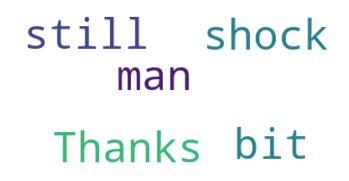

In [39]:
# Start with the first parent comment:
from wordcloud import WordCloud
example = red_sample.comment[0]
print(example)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(example)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Wordcloud on all the comments.

In [40]:
# Wordcloud
def myWordCloud(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_sample['comment'][red_sample["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

Wordcloud for Non sarcastic comments:

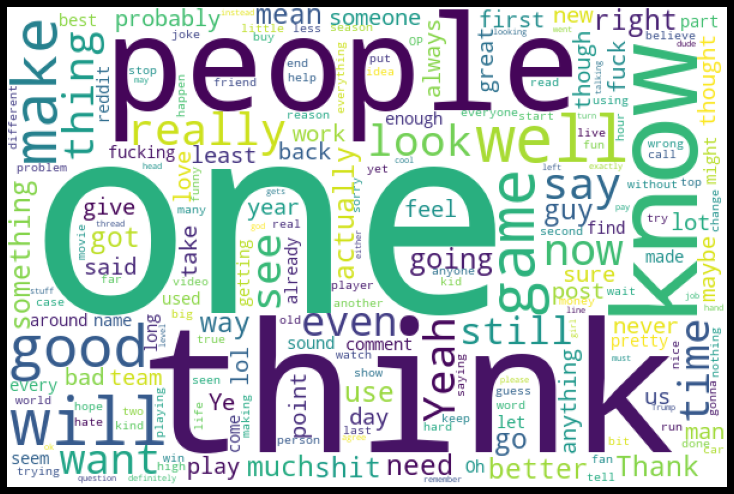

In [41]:
myWordCloud(0)

Wordcloud for Sarcastic comments:

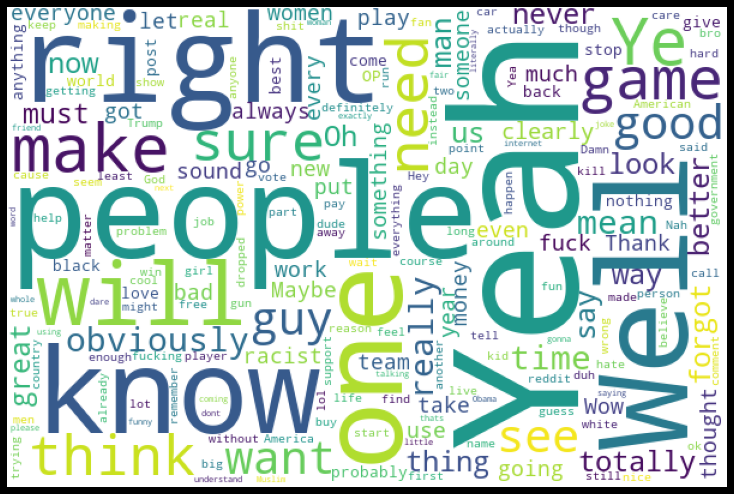

In [42]:
myWordCloud(1)

#### Wordcloud with the cleaned version of the comments:

In [43]:
# Word cloud
def myWordCloudCleaned(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_sample['clean'][red_sample["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

Wordcloud for Non sarcastic comments:

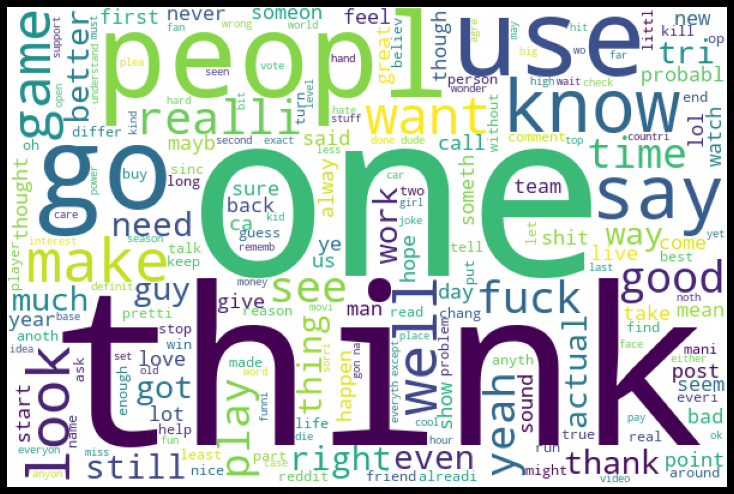

In [44]:
myWordCloudCleaned(0)

Wordcloud for Sarcastic comments:

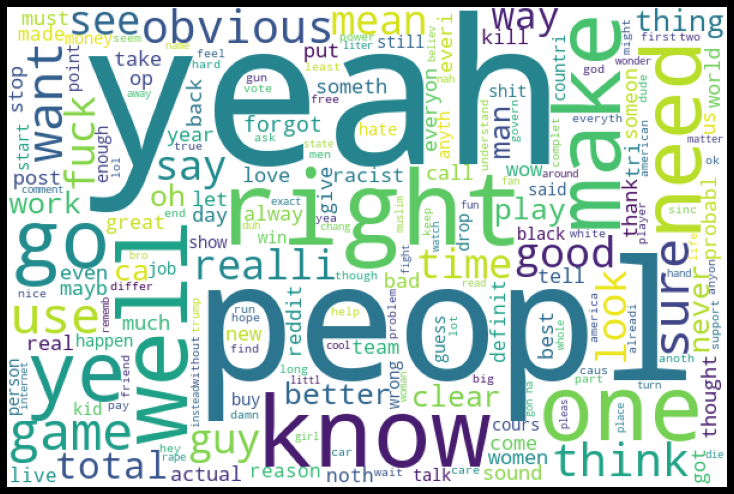

In [45]:
myWordCloudCleaned(1)

## Split into train and test sets

In [46]:
## Let's check the number of unique values in the subreddit columns
red_sample['subreddit'].nunique()

4099

In [47]:
X = red_final.drop(['label'], axis = 1) 
y = red_final["label"]

In [ ]:
#X = red_sample[['clean','subreddit']]
#y = red_sample['label']

In [48]:
X_train, red_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=28)

In [49]:
red_train, red_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=28)

In [50]:
print(red_train.shape)
print(red_val.shape)
print(red_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(32344, 19)
(8087, 19)
(10108, 19)
(32344,)
(8087,)
(10108,)


## Classification algorithms

### First alternative
In the first alternative we wll have separate Tf-Idf vectorizers for comments and for subreddits.

#### TF-IDF on cleaned comments
TF-IDF focusing on the comments from which we have removed the punctuation and on which we have performed stemmization.

In [51]:
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
comment_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=3)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [53]:
clean_train = comment_vectorizer.fit_transform(red_train['clean'])
clean_valid = comment_vectorizer.transform(red_val['clean'])
clean_test = comment_vectorizer.transform(red_test['clean'])

In [54]:
subred_train = subreddits_vectorizer.fit_transform(red_train['subreddit'])
subred_valid = subreddits_vectorizer.transform(red_val['subreddit'])
subred_test = subreddits_vectorizer.transform(red_test['subreddit'])

In [55]:
reddit_train = hstack([clean_train, subred_train])
reddit_valid = hstack([clean_valid, subred_valid])
reddit_test = hstack([clean_test, subred_test])

In [56]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
NB = MultinomialNB()
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#### Naive Bayes

In [57]:
naive_bayes1 = NB.fit(reddit_train, y_train)

In [58]:
naiveBayes_predict1 = naive_bayes1.predict(reddit_test)

In [59]:
metrics.accuracy_score(y_test, naiveBayes_predict1)

0.6372180451127819

With Cross Validation

In [60]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

In [61]:
NB_cv1 = cross_val_score(NB, reddit_train, y_train, n_jobs = -1)
NB_cv1

array([0.62297109, 0.6368836 , 0.62188901, 0.62467151, 0.64131107])

#### Logistic Regression

In [62]:
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [63]:
## Fit the model
logit_model1 = logit.fit(reddit_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished


In [64]:
from sklearn.metrics import roc_auc_score, confusion_matrix
roc_auc_score(y_test, logit_model1.predict_proba(reddit_test)[:,1])

0.7097226751230428

With Cross validation:

In [65]:
logit_cv1 = cross_val_score(logit, reddit_train, y_train, n_jobs = -1)
logit_cv1

array([0.6424486 , 0.65048694, 0.63209151, 0.63703818, 0.64904143])

#### Random forest

In [66]:
random_forest = RandomForestClassifier(max_depth=10, max_features=10)
rf_model1 = random_forest.fit(reddit_train, y_train)

In [67]:
randomForest_predict1 = rf_model1.predict(reddit_test)

In [68]:
metrics.accuracy_score(y_test, randomForest_predict1)

0.5800356153541749

With Cross validation:

In [69]:
rf_cv1 = cross_val_score(random_forest, reddit_train, y_train, n_jobs = -1)
rf_cv1

array([0.56206523, 0.5912815 , 0.58803525, 0.59731025, 0.58147805])

## Second Alternative

Adding the subreddit to the comment and therefore conduct the analysis on the combination of the two: since the subreddits are not classified as stopwords when parsing the comments they should not be removed, thus appearing in the cleaned version of the comments.

In [70]:
red_sample.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_parent
0,0,"Thanks man, I'm still in a bit of a shock.",india,0,0,"Aw, my condolences",42,3,10,thank man still bit shock,aw condol
1,0,You would think that she'd at least want to ta...,agentcarter,3,0,How is she not sweating like a hog in that out...,64,2,13,would think least want take jacket,sweat like hog outfit
2,1,because everyone is a criminal and should be a...,technology,1,0,FBI renews broad Internet surveillance push. T...,354,4,62,everyon crimin assum guilti live ruin fals acc...,fbi renew broad internet surveil push fbi rene...
3,1,"Right, cuz it's so hard to aim with a mouse.",battlefield_4,3,0,"nice aim assist, console peasant.",44,3,10,right cuz hard aim mous,nice aim assist consol peasant
4,1,Por suerte esta gente no se reproduce,argentina,-1,-1,Nacen los 'ecosexuales': hacen el amor con la ...,37,0,7,por suert esta gent se reproduc,nacen los hacen el amor con la tierra para sal...


In [72]:
red_sample['text'] = red_sample.clean + " " + red_sample.subreddit
red_sample.head()

,label,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_parent,text
0,0,"Thanks man, I'm still in a bit of a shock.",india,0,0,"Aw, my condolences",42,3,10,thank man still bit shock,aw condol,thank man still bit shock india
1,0,You would think that she'd at least want to ta...,agentcarter,3,0,How is she not sweating like a hog in that out...,64,2,13,would think least want take jacket,sweat like hog outfit,would think least want take jacket agentcarter
2,1,because everyone is a criminal and should be a...,technology,1,0,FBI renews broad Internet surveillance push. T...,354,4,62,everyon crimin assum guilti live ruin fals acc...,fbi renew broad internet surveil push fbi rene...,everyon crimin assum guilti live ruin fals acc...
3,1,"Right, cuz it's so hard to aim with a mouse.",battlefield_4,3,0,"nice aim assist, console peasant.",44,3,10,right cuz hard aim mous,nice aim assist consol peasant,right cuz hard aim mous battlefield_4
4,1,Por suerte esta gente no se reproduce,argentina,-1,-1,Nacen los 'ecosexuales': hacen el amor con la ...,37,0,7,por suert esta gent se reproduc,nacen los hacen el amor con la tierra para sal...,por suert esta gent se reproduc argentina


In [73]:
# We drop all the columns of the comments and that containing the cleaned text:
red_sample.drop(['comment', 'clean'], axis=1, inplace=True)
red_sample.head(10)

,label,subreddit,ups,downs,parent_comment,char,punct,tokens,clean_parent,text
0,0,india,0,0,"Aw, my condolences",42,3,10,aw condol,thank man still bit shock india
1,0,agentcarter,3,0,How is she not sweating like a hog in that out...,64,2,13,sweat like hog outfit,would think least want take jacket agentcarter
2,1,technology,1,0,FBI renews broad Internet surveillance push. T...,354,4,62,fbi renew broad internet surveil push fbi rene...,everyon crimin assum guilti live ruin fals acc...
3,1,battlefield_4,3,0,"nice aim assist, console peasant.",44,3,10,nice aim assist consol peasant,right cuz hard aim mous battlefield_4
4,1,argentina,-1,-1,Nacen los 'ecosexuales': hacen el amor con la ...,37,0,7,nacen los hacen el amor con la tierra para sal...,por suert esta gent se reproduc argentina
5,1,nfl,2,0,People still argue Moss couldn't run block...,74,1,14,peopl still argu moss could run block,terribl rout runner couldni run catch either nfl
6,1,AskReddit,-1,-1,"I live in Los Angeles, and you'll often hear t...",50,3,10,live los angel often hear peopl want work ente...,yea get scientologist AskReddit
7,1,OFWGKTA,5,0,I actually believe you. I think you might be t...,15,0,3,actual believ think might tyler also,forgot OFWGKTA
8,1,atheism,1,0,Pastor outed on Ashley Madison commits suicide,33,3,6,pastor out ashley madison commit suicid,oh peac jesus bring atheism
9,0,GuessTheMovie,1,0,Body Double?,57,2,12,bodi doubl,film share genr accord imdb GuessTheMovie


#### Wordclouds with the new text:

In [74]:
def myWordCloudText(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_sample['text'][red_sample["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

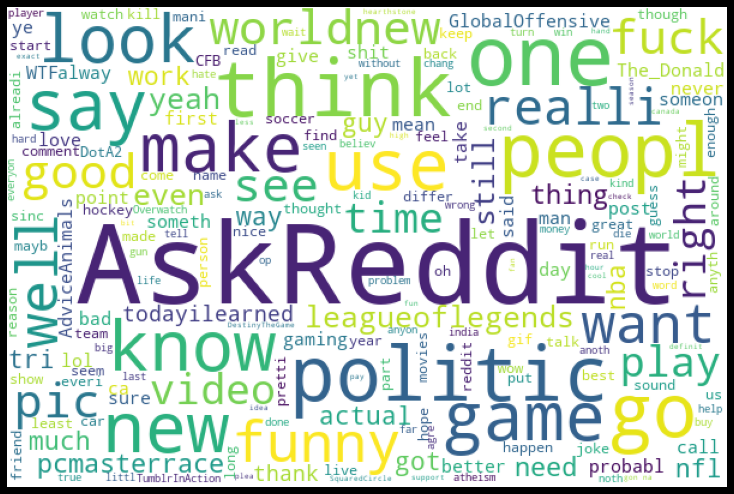

In [75]:
## Wordcloud for Non sarcastic comments
myWordCloudText(0)

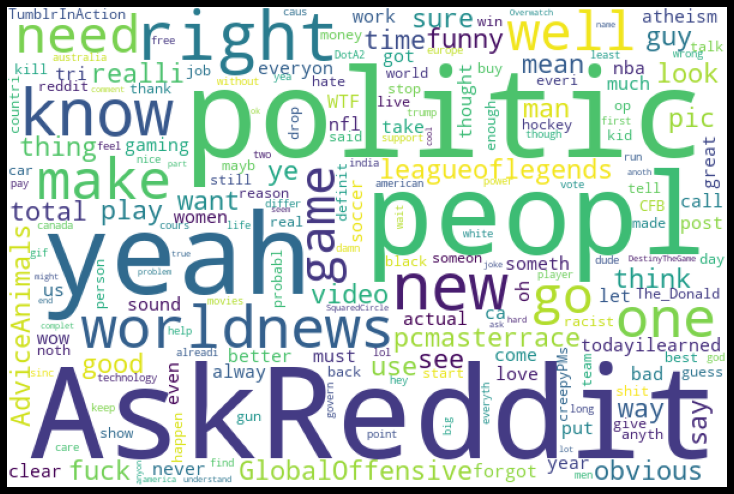

In [76]:
## Wordcloud for Non sarcastic comments
myWordCloudText(1)

In [77]:
X2 = red_sample[['text']]
y2 = red_sample['label']

In [78]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [79]:
reddit_train2 = comment_vectorizer.fit_transform(X_train2['text'])
reddit_test2 = comment_vectorizer.transform(red_test2['text'])

#### Naive Bayes

In [80]:
naive_bayes2 = NB.fit(reddit_train2, y2_train)

In [81]:
naiveBayes_predict2 = NB.predict(reddit_test2)

In [82]:
metrics.accuracy_score(y2_test, naiveBayes_predict2)

0.6496834190740008

Cross Validation:

In [83]:
NB_cv2 = cross_val_score(NB, reddit_train2, y2_train, n_jobs = -1)
NB_cv2

array([0.63917398, 0.64222112, 0.6393767 , 0.63640861, 0.63925303])

#### Random forest

In [84]:
random_forest.fit(reddit_train2, y2_train)

RandomForestClassifier(max_depth=10, max_features=10)

In [85]:
randomForest_predict2 = random_forest.predict(reddit_test2)

In [86]:
metrics.accuracy_score(y2_test, randomForest_predict2)

0.5833003561535417

Cross Validation:

In [87]:
rf_cv2 = cross_val_score(random_forest, reddit_train2, y2_train, n_jobs = -1)
rf_cv2

array([0.58649685, 0.58929013, 0.58929013, 0.58162256, 0.58421964])

#### Logistic regression

In [88]:
X3 = red_sample['text']
y3 = red_sample['label']

In [89]:
X_train3, red_test3, y3_train, y3_test = train_test_split(X3, y3, test_size=0.20, random_state=28)

In [90]:
from sklearn.pipeline import Pipeline
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [91]:
tfidf_logit_pipeline.fit(X_train3, y3_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.7s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [92]:
roc_auc_score(y3_test, tfidf_logit_pipeline.predict_proba(red_test3)[:,1])

0.7195711144085424

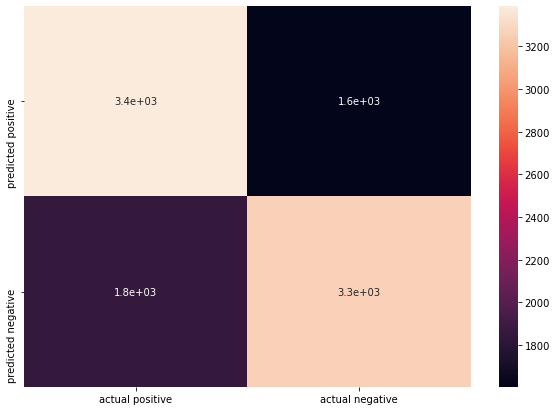

In [93]:
conf_mat3 = pd.DataFrame(confusion_matrix(y3_test, tfidf_logit_pipeline.predict(red_test3)), index = ['predicted positive', 'predicted negative'],
                  columns = ['actual positive', 'actual negative'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat3, annot=True)
plt.show()

GridSeachCV:

In [94]:
model = Pipeline([('tfidf',TfidfVectorizer(min_df=2)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
parameters = {'tfidf__ngram_range':[(1,1),(1,2)],'tfidf__use_idf':(True,False)}

In [95]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2,n_jobs=-1, cv=3, refit=True)

In [96]:
grid.fit(X_train3, y3_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    4.0s remaining:    8.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.8s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2)),
                                       ('logit',
                                        LogisticRegression(max_iter=3000))]),
             n_jobs=-1,
             param_grid={'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__use_idf': (True, False)},
             verbose=2)

In [97]:
chosen_model = Pipeline([('tfidf',TfidfVectorizer(min_df=2, ngram_range=(1,2), use_idf=True)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
chosen_model.fit(X_train3, y3_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('logit', LogisticRegression(max_iter=3000))])

In [98]:
from sklearn.metrics import accuracy_score
predictions = chosen_model.predict(red_test3)
print('Accuracy Score: {:.2%}'.format(accuracy_score(y3_test,predictions)),'\n')

Accuracy Score: 65.83% 



### Third Alternative

In [99]:
def addFeature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [100]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
NB = MultinomialNB()
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier as xgboost
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [101]:
X.head()

,comment,subreddit,ups,downs,parent_comment,char,punct,tokens,clean,clean_parent,sentiment,keywords_parent,keywords_children,common_words,overlap_count,cap,uppercase,polarity,subjectivity
0,"Thanks man, I'm still in a bit of a shock.",india,0,0,"Aw, my condolences",42,3,10,thank man still bit shock,aw condol,Positive,"{condol, aw}","{still, bit, man, thank, shock}",{},0,0,1,0.200000,0.200000
1,You would think that she'd at least want to ta...,agentcarter,3,0,How is she not sweating like a hog in that out...,64,2,13,would think least want take jacket,sweat like hog outfit,Positive,"{sweat, outfit, hog, like}","{think, jacket, would, least, take, want}",{},0,0,1,-0.300000,0.400000
2,because everyone is a criminal and should be a...,technology,1,0,FBI renews broad Internet surveillance push. T...,354,4,62,everyon crimin assum guilti live ruin fals acc...,fbi renew broad internet surveil push fbi rene...,Highly Negative,"{internet, warn, build, renew, fbi, surveil, p...","{oversight, evid, difficult, fals, judg, pet, ...",{},0,0,9,-0.365079,0.656576
3,"Right, cuz it's so hard to aim with a mouse.",battlefield_4,3,0,"nice aim assist, console peasant.",44,3,10,right cuz hard aim mous,nice aim assist consol peasant,Highly Negative,"{nice, peasant, consol, aim, assist}","{cuz, mous, aim, right, hard}",{aim},1,0,0,-0.002976,0.538690
4,Por suerte esta gente no se reproduce,argentina,-1,-1,Nacen los 'ecosexuales': hacen el amor con la ...,37,0,7,por suert esta gent se reproduc,nacen los hacen el amor con la tierra para sal...,Highly Negative,"{nacen, salvar, planeta, con, hacen, amor, tie...","{reproduc, esta, gent, por, se, suert}",{},0,0,2,0.000000,0.000000


In [102]:
X_train3, red_test3, y_train_prov, y_test3 = train_test_split(X, y, test_size=0.20, random_state=28)

In [103]:
red_train3, red_val3, y_train3, y_val3 = train_test_split(X_train3, y_train_prov, test_size=0.2, random_state=28)

In [104]:
parent_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
sentiment_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [105]:
clean_train3 = parent_vectorizer.fit_transform(red_train3['clean'])
clean_valid3 = parent_vectorizer.transform(red_val3['clean'])
clean_test3 = parent_vectorizer.transform(red_test3['clean'])

In [106]:
subred_train3 = subreddits_vectorizer.fit_transform(red_train3['subreddit'])
subred_valid3 = subreddits_vectorizer.transform(red_val3['subreddit'])
subred_test3 = subreddits_vectorizer.transform(red_test3['subreddit'])

In [107]:
sent_train = sentiment_vectorizer.fit_transform(red_train3['sentiment'])
sent_valid = sentiment_vectorizer.transform(red_val3['sentiment'])
sent_test = sentiment_vectorizer.transform(red_test3['sentiment'])

reddit_train3 = hstack([subred_train3, sent_train])
reddit_valid3 = hstack([subred_valid3, sent_valid])
reddit_test3 = hstack([subred_test3, sent_test])

In [108]:
reddit_train1_3 = hstack([clean_train3, subred_train3])
reddit_valid1_3 = hstack([clean_valid3, subred_valid3])
reddit_test1_3 = hstack([clean_test3, subred_test3])

In [109]:
reddit_train3 = hstack([reddit_train1_3, sent_train])
reddit_valid3 = hstack([reddit_valid1_3, sent_valid])
reddit_test3 = hstack([reddit_test1_3, sent_test])

In [110]:
reddit_train3 = addFeature(reddit_train3, red_train3['overlap_count'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['overlap_count'])
reddit_test3 = addFeature(reddit_test3, red_test3['overlap_count'])

In [111]:
reddit_train3 = addFeature(reddit_train3, red_train3['char'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['char'])
reddit_test3 = addFeature(reddit_test3, red_test3['char'])

In [112]:
reddit_train3 = addFeature(reddit_train3, red_train3['cap'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['cap'])
reddit_test3 = addFeature(reddit_test3, red_test3['cap'])

In [113]:
reddit_train3 = addFeature(reddit_train3, red_train3['punct'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['punct'])
reddit_test3 = addFeature(reddit_test3, red_test3['punct'])

In [114]:
reddit_train3 = addFeature(reddit_train3, red_train3['uppercase'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['uppercase'])
reddit_test3 = addFeature(reddit_test3, red_test3['uppercase'])

In [115]:
reddit_train3 = addFeature(reddit_train3, red_train3['ups'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['ups'])
reddit_test3 = addFeature(reddit_test3, red_test3['ups'])

In [116]:
reddit_train3 = addFeature(reddit_train3, red_train3['downs'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['downs'])
reddit_test3 = addFeature(reddit_test3, red_test3['downs'])

In [117]:
reddit_train3 = addFeature(reddit_train3, red_train3['polarity'])
reddit_valid3 = addFeature(reddit_valid3, red_val3['polarity'])
reddit_test3 = addFeature(reddit_test3, red_test3['polarity'])

#### XGBoost

In [118]:
xgboost = XGBClassifier()
xgboost_model3 = xgboost.fit(reddit_train3, y_train3)
y_pred_xgboost3 = xgboost_model3.predict(reddit_test3)

In [119]:
accuracy_xgboost3 = accuracy_score(y_test3, y_pred_xgboost3)
print("Accuracy: %.2f%%" % (accuracy_xgboost3 * 100.0))

Accuracy: 63.04%


Confusion matrix:
 [[3714 1278]
 [2458 2658]]


C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
C:\Users\liry9\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


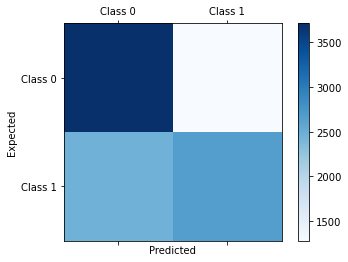

In [120]:
conf_mat_xbgoost3 = confusion_matrix(y_true = y_test3, y_pred = y_pred_xgboost3)
print('Confusion matrix:\n', conf_mat_xbgoost3)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat_xbgoost3, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

#### Logistic Regression

In [121]:
## Fit the model
logit_model3 = logit.fit(reddit_train3, y_train3)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished


In [122]:
y_pred_logit3 = logit_model3.predict(reddit_test3)

Accurcay 0.5717253660466957
Precision 0.5752246224431276
Recall 0.588154808444097
F1 score 0.5816178602493477


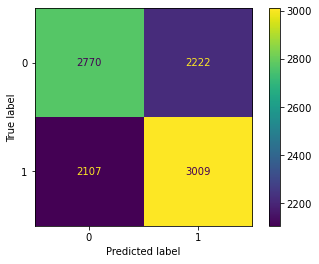

In [123]:
# print the model performance metrics
print("Accurcay",accuracy_score(y_test3, y_pred_logit3))
print("Precision", precision_score(y_test3, y_pred_logit3))
print("Recall",recall_score(y_test3, y_pred_logit3))
print("F1 score",f1_score(y_test3, y_pred_logit3))
plot_confusion_matrix(logit_model3, reddit_test3, y_test3)

#### KNN

In [124]:
knn_model3 = knn.fit(reddit_train3, y_train3)

In [125]:
y_knn_pred3 = knn_model3.predict(reddit_test3)
y_knn_pred3

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [126]:
print(knn_model3.score(reddit_test3, y_test3))

0.5462999604273843


#### Random Forest

In [127]:
random_forest_model3 = random_forest.fit(reddit_train3, y_train3)

In [128]:
randomForest_predict3 = random_forest_model3.predict(reddit_test3)

In [129]:
metrics.accuracy_score(y_test3, randomForest_predict3)

0.5769687376335576

Cross Validation

In [130]:
rf_cv3 = cross_val_score(random_forest_model3, reddit_train3, y_train3, n_jobs = -1)
rf_cv3

array([0.57675066, 0.57798732, 0.56531149, 0.57566857, 0.57560297])